In [1]:
%matplotlib inline

import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

import joblib
from skimage.io import imread
from skimage.transform import resize

from collections import Counter

from sklearn.model_selection import train_test_split

from lazypredict.Supervised import LazyClassifier

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6063534778002689700
]


In [3]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 16} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [4]:
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})class images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [5]:
data_path = 'seg_train/seg_train'
os.listdir(data_path)

['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']

In [6]:
base_name = 'class_names'
width = 80
 
include = {'forest', 'buildings', 'glacier', 'street', 'mountain', 'sea'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

forest
buildings
glacier
street
mountain
sea


In [7]:
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  14034
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)class images in rgb
image shape:  (80, 80, 3)
labels: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Counter({'forest': 2271,
         'buildings': 2191,
         'glacier': 2404,
         'street': 2382,
         'mountain': 2512,
         'sea': 2274})

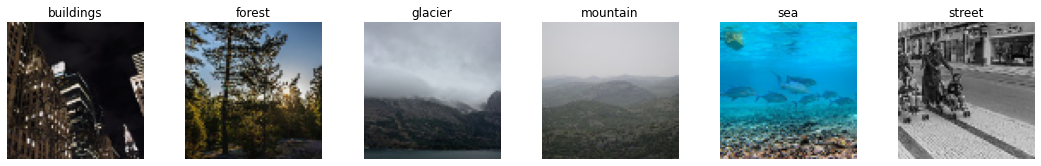

In [8]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [9]:
X = np.array(data['data'])
y = np.array(data['label'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, random_state=42)

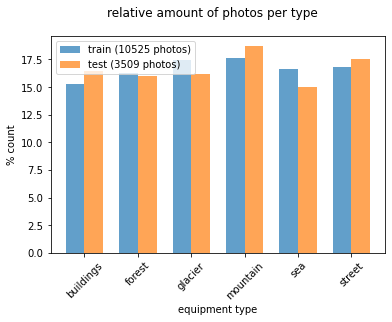

In [11]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
    plt.suptitle('relative amount of photos per type')

    
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

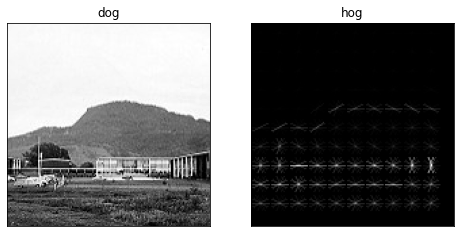

In [12]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
buildings = imread('seg_train/seg_train/buildings/0.jpg', as_gray=True)
 
# scale down the image to one third
# buildings = rescale(buildings, 1/8, mode='reflect')

# calculate the hog and return a visual representation.
buildings_hog, buildings_hog_img = hog(
    buildings, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(buildings, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(buildings_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [13]:
print('number of pixels: ', buildings.shape[0] * buildings.shape[1])
print('number of hog features: ', buildings_hog.shape[0])

number of pixels:  22500
number of hog features:  2916


In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     

In [15]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(10525, 576)


In [17]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [18]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [19]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True False  True  True  True  True  True False  True False  True  True
 False  True False False False False  True  True False  True  True  True
 False]

Percentage correct:  57.42376745511542


In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix

label_names = labels
cmx = confusion_matrix(y_test, y_pred, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,buildings,forest,glacier,mountain,sea,street
label,,,,,,
buildings,364,15,31,58,33,78
forest,12,472,15,10,19,34
glacier,23,15,311,126,58,36
mountain,13,1,249,274,97,23
sea,23,2,188,128,174,12
street,92,31,37,14,21,420


In [21]:
X_train.shape

(10525, 80, 80, 3)


 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


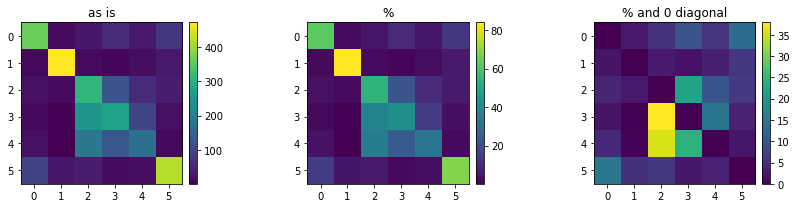

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

In [23]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  57.42376745511542


In [24]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

In [25]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='f1_macro',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed: 20.6min finished


In [26]:
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(pixels_per_cell=(10, 10))),
                ('scalify', StandardScaler()),
                ('classify', SGDClassifier(random_state=42))])

In [27]:
grid_res.best_score_

0.6477246925661636

In [28]:
pp.pprint(grid_res.best_params_)

{   'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 9,
    'hogify__pixels_per_cell': (10, 10)}


In [29]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  65.8592191507552


In [30]:
cmx_svm = confusion_matrix(y_test, best_pred)

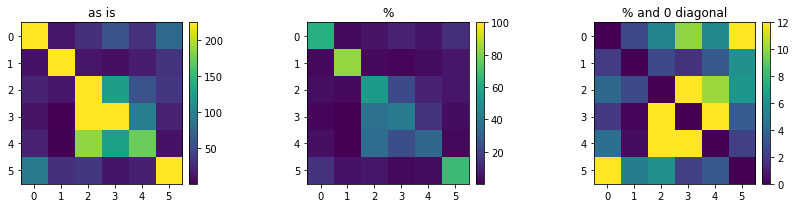

In [31]:
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

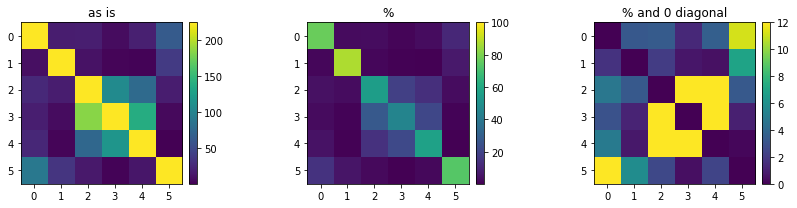

In [32]:
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)

In [33]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

In [34]:
!ls seg_train/seg_train

buildings forest    glacier   mountain  sea       street


In [35]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'seg_train/seg_train',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

Found 14037 files belonging to 6 classes.
Using 11230 files for training.


In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'seg_test/seg_test',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

Found 3000 files belonging to 6 classes.
Using 2400 files for training.


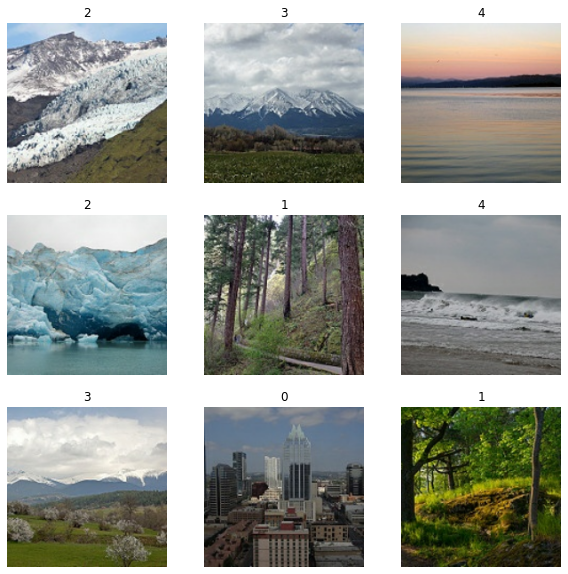

In [37]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')

In [38]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal'),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

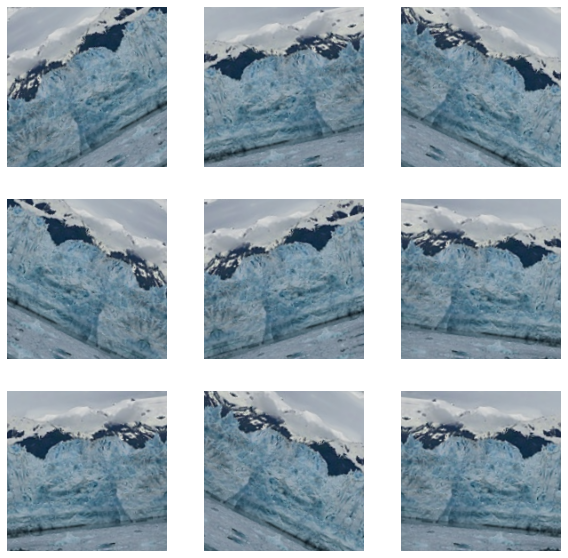

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [40]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)

In [41]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

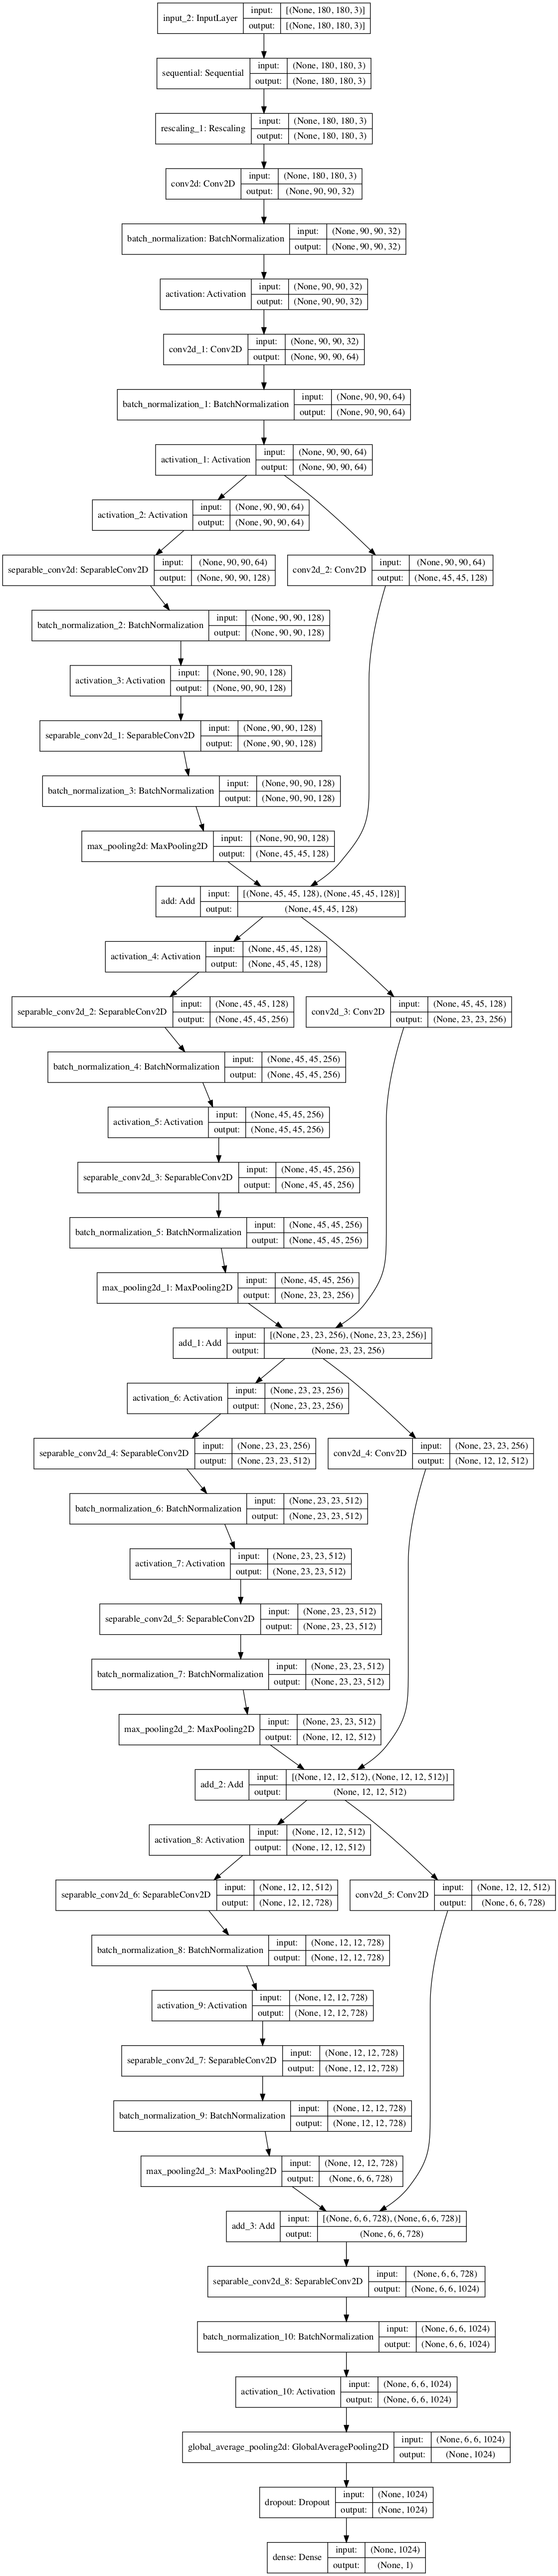

In [42]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [43]:
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [44]:
import numpy as np
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
import keras.applications as kapp
from tensorflow.keras.applications import VGG19
from keras.datasets import cifar10

(x_train, y_train_cats), (x_test, y_test_cats) = cifar10.load_data()
batch_size = 8
x_train = x_train[:batch_size]
x_train = np.repeat(np.repeat(x_train, 7, axis=1), 7, axis=2)
model = VGG19()
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Running initial batch (compiling tile program)")
y = model.predict(x=x_train, batch_size=batch_size)

# Now start the clock and run 10 batches
print("Timing inference...")
start = time.time()
for i in range(10):
    y = model.predict(x=x_train, batch_size=batch_size)
print("Ran in {} seconds".format(time.time() - start))

Running initial batch (compiling tile program)
Timing inference...
Ran in 5.947066068649292 seconds


In [45]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

AttributeError: module 'keras.optimizers' has no attribute 'Adam'